## Imports

In [1]:
import numpy as np
import xarray as xr
from os import makedirs, path, listdir, remove
import matplotlib.pyplot as plt

## Code

Choose a run:

In [73]:
run = "003"

folder = f"/home/users/mwlw3/ADMS-Urban/2018_P-G_classes/all_regions/{run}/"
files = [path.join(folder, file) for file in listdir(folder) if path.splitext(file)[-1]==".nc"]
griddings = [path.join(folder, item) for item in listdir(folder) if path.isdir(path.join(folder, item)) and item.split("_")[0]=="gridded"]
print(f"We have {len(griddings)} folders with gridded data in them:")
for i, grid in enumerate(griddings):
    print(i, grid.split("/")[-1])

We have 2 folders with gridded data in them:
0 gridded
1 gridded_295


Choose a folder and pollutant species:

In [74]:
coordinate_system = griddings[1] # "gridded****" or "raw_latlon"
variable = "NO2"

if coordinate_system == "raw_latlon":
    filepath = path.join(folder, "raw_processed_coordinates.nc")
else:
    filepath = path.join(folder, f"{coordinate_system}/", f"{variable}_PG_classes_grid.nc")

ds = xr.open_dataset(filepath)

Choose a Pasquill-Gifford class:

In [75]:
choose_PG_class = "A"

PG_index = ["A", "B", "C", "D", "E", "F", "G"]
da = ds.isel(PG_class=PG_index.index(choose_PG_class))[variable]
# da = ds[variable][:, :, PG_index.index(choose_PG_class)]
array = np.rot90(da.values)
print(f"The chosen data array has shape {array.shape}.")

The chosen data array has shape (165, 296).


Fill the edge NaN values:

In [76]:
print("Before: ", np.sum(np.isnan(array)), f"NaN values ({((np.sum(np.isnan(array)) / (array.shape[0] * array.shape[1]))*100).round()}%)")
array[np.isnan(array)] = array[np.isnan(array)==False].mean()
print("After: ", np.sum(np.isnan(array)), "NaN values")

Before:  4144 NaN values (8.0%)
After:  0 NaN values


Plot the gridded data!

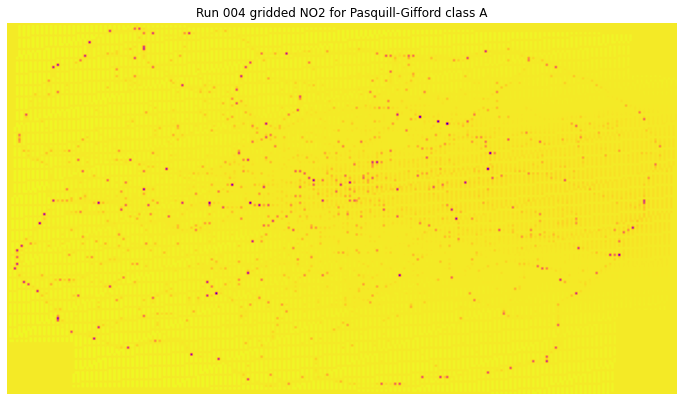

In [68]:
fig, ax = plt.subplots(figsize=(12,7))
ax.imshow(array, cmap="plasma_r")
ax.axis("off")
plt.title(f"Run {run} gridded {variable} for Pasquill-Gifford class {choose_PG_class}")
plt.show()

Now we perform singular value decomposition (SVD):

In [69]:
U, S, Vt = np.linalg.svd(array) # default is full_matrices=True
# print(U.shape, S.shape, Vt.shape)

# Turn the S vector into a diagonal matrix
S_matrix = np.zeros((U.shape[1], Vt.shape[0]))
S_matrix[:np.diag(S).shape[0], :np.diag(S).shape[1]] = np.diag(S)
print(f"Our matrices have shapes \nU {U.shape}\nS {S_matrix.shape}\nVt {Vt.shape}.")

# Does U . S_matrix . Vt = array ?
if np.allclose(array, np.dot(U, np.dot(S_matrix, Vt))):
    print("SVD worked!")

Our matrices have shapes 
U (164, 164)
S (164, 296)
Vt (296, 296).
SVD worked!


Plot the SVD:

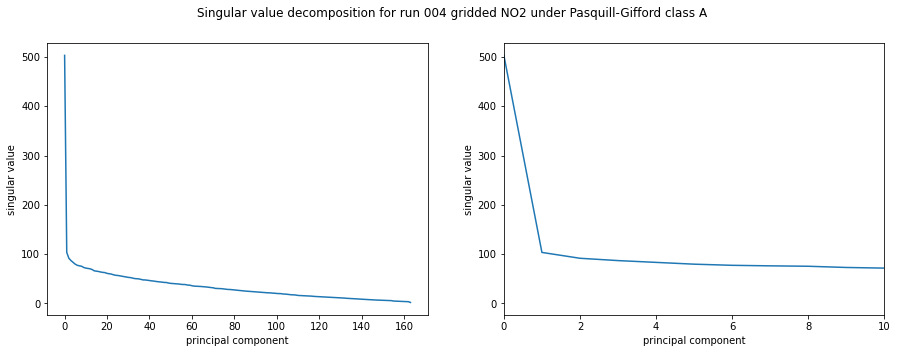

In [70]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))
for ax in (ax1, ax2):
    ax.plot(S)
    ax.set_xlabel("principal component")
    ax.set_ylabel("singular value")
ax2.set_xlim((0, 10))
fig.suptitle(f"Singular value decomposition for run {run} gridded {variable} under Pasquill-Gifford class {choose_PG_class}")
plt.show()

Want to plot a single principal component?

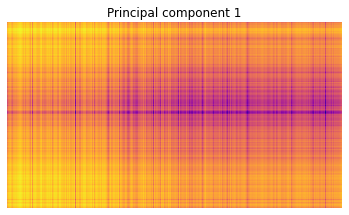

In [71]:
# Plot a principal component
choose = 1
component = np.dot(U[:, :choose], np.dot(S_matrix[:choose, :choose], Vt[:choose, :]))
plt.imshow(component, cmap="plasma_r")
plt.title(f"Principal component {choose}")
plt.axis("off")
plt.show()

Specify a list of principal components to plot together:

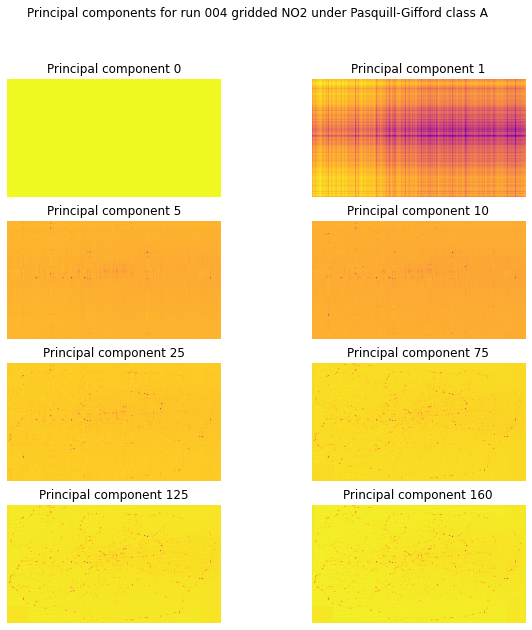

In [72]:
PCs_to_plot = [0, 1, 5, 10, 25, 75, 125, 160]
rows = 4
columns = 2

if rows * columns == len(PCs_to_plot):
    fig, axs = plt.subplots(rows, columns, figsize=(10,10))
    axs = axs.ravel()

    for i in range(len(axs)):
        PC = PCs_to_plot[i]
        component = np.dot(U[:, :PC], np.dot(S_matrix[:PC, :PC], Vt[:PC, :]))
        axs[i].imshow(component, cmap="plasma_r")
        axs[i].set_title(f"Principal component {PC}")
        axs[i].axis("off")
    fig.suptitle(f"Principal components for run {run} gridded {variable} under Pasquill-Gifford class {choose_PG_class}")
    plt.show()
else:
    print("Change the specification of rows and columns.")